In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error

In [2]:
df_movies = pd.read_csv('datasets_\ml-latest-small\movies.csv')
df_rating = pd.read_csv(r'datasets_\ml-latest-small\ratings.csv')
df =  pd.merge(df_rating, df_movies, on='movieId')

In [3]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [4]:
user_item_matrix = df.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

In [5]:
user_similarity = cosine_similarity(user_item_matrix)

# Step 3: Convert to a DataFrame for better readability
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

print("User-User Cosine Similarity Matrix:")
user_similarity_df

User-User Cosine Similarity Matrix:


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
607,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
608,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055


In [6]:
target_user = 1
x = df[df['userId'] == target_user]

In [43]:
def get_weighted_average_predictions(target_user, df, user_similarity_df, top_n_similar=5):
    """Calculates weighted average predicted ratings for all movies based on top N similar users."""
    if target_user not in user_similarity_df.index:
        return pd.Series()
    #Top user similar to target
    similar_users = user_similarity_df.loc[target_user].drop(target_user).sort_values(ascending=False).head(top_n_similar).index
    #Their Values
    similar_scores = user_similarity_df.loc[target_user].drop(target_user).sort_values(ascending=False).head(top_n_similar).values

    weighted_ratings_list = []  # Use a list to collect DataFrames
    #summation of similar scres
    sum_scores = sum(similar_scores) if similar_scores.any() else 1e-6 # Avoid division by zero
    #calculating weighted avera9ge x1*weight1 + x2*weight2)/(sum_scores)
    for user, score in zip(similar_users, similar_scores):
        user_ratings = df[df['userId'] == user][['movieId', 'rating']].copy()
        if not user_ratings.empty:  # Check if the user has any ratings
            user_ratings['weighted_rating'] = user_ratings['rating'] * score
            weighted_ratings_list.append(user_ratings)
    #if empty
    if not weighted_ratings_list:
        return pd.Series()

    weighted_ratings = pd.concat(weighted_ratings_list, ignore_index=True)

    predicted_avg = weighted_ratings.groupby(['movieId'])['weighted_rating'].sum() / sum_scores
    return predicted_avg

predicted_avg = get_weighted_average_predictions(target_user, df, user_similarity_df)


In [44]:
predicted_avg.head()

movieId
1     2.179472
2     0.579160
3     1.176315
6     3.791293
10    2.680886
Name: weighted_rating, dtype: float64

In [45]:
#listing top 10 movies
predicted_movies = predicted_avg.sort_values().head(10)
predicted_movies = predicted_movies.to_frame()
predicted_movies.reset_index(inplace = True)
predicted_movies.columns
for i in predicted_movies['movieId']:
    print( df[df['movieId'] == i]['title'].head(1).to_string() )

14369    Spice World (1997)
6107    Simon Birch (1998)
7693    Animal, The (2001)
6845    Ernest Scared Stupid (1991)
738    Richie Rich (1994)
3383    Charlie's Angels: Full Throttle (2003)
752    City Slickers II: The Legend of Curly's Gold (...
14447    Frankenstein Meets the Wolf Man (1943)
14587    Big Trouble (2002)
14577    Earth Girls Are Easy (1988)


In [46]:
y = predicted_avg.to_frame()
df_target = pd.merge(x,y, on='movieId')
print('The mse Score = ',mean_squared_error(df_target['rating'], df_target['weighted_rating']))
print('The r2 Score = ',r2_score(df_target['rating'], df_target['weighted_rating']))

The mse Score =  7.397367481740456
The r2 Score =  -10.751777522514747


In [47]:
# Get movies already rated by the target user
rated_by_target = set(df[df['userId'] == target_user]['movieId'])

# Filter predicted ratings for movies not yet rated by the target user
unrated_predictions = predicted_avg[~predicted_avg.index.isin(rated_by_target)]

# Sort predictions in descending order
top_recommendations = unrated_predictions.sort_values(ascending=False).head(10) # Get top 10 recommendations

print(f"Top recommendations for user {target_user}: {top_recommendations.index.tolist()}")

Top recommendations for user 1: [1200, 1610, 541, 589, 1036, 858, 924, 1374, 2791, 1221]


In [15]:
def evaluate_recommendations_weighted(df, user_similarity_df, top_n_recommendations=10, rating_threshold=4, test_size=0.2):
    """Evaluates weighted average based recommendations using precision and recall."""
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    precision_sum = 0
    recall_sum = 0
    num_users = 0

    for target_user in test_df['userId'].unique():
        # Get predictions based on the training data
        predictions = get_weighted_average_predictions(target_user, train_df, user_similarity_df, top_n_similar=5)

        # Get movies the target user actually liked in the test set
        relevant_items = set(test_df[(test_df['userId'] == target_user) & (test_df['rating'] >= rating_threshold)]['movieId'])

        # Get top N recommendations based on predictions for unrated items in training
        train_rated_items = set(train_df[train_df['userId'] == target_user]['movieId'])
        recommendations = predictions[~predictions.index.isin(train_rated_items)].nlargest(top_n_recommendations).index.tolist()

        if not recommendations:
            precision = 0
            recall = 0
        else:
            recommended_relevant = len(set(recommendations) & relevant_items)
            precision = recommended_relevant / len(recommendations)
            recall = recommended_relevant / len(relevant_items) if relevant_items else 0

        precision_sum += precision
        recall_sum += recall
        num_users += 1

    if num_users > 0:
        mean_precision = precision_sum / num_users
        mean_recall = recall_sum / num_users
        return mean_precision, mean_recall
    else:
        return 0, 0

# Assuming you have 'df' (your ratings DataFrame) and 'user_similarity_df' already computed

mean_precision, mean_recall = evaluate_recommendations_weighted(df.copy(), user_similarity_df.copy(), top_n_recommendations=10, rating_threshold=4)
print(f"Mean Precision (Weighted Average): {mean_precision:.4f}")
print(f"Mean Recall (Weighted Average): {mean_recall:.4f}")

# Example of getting recommendations for a specific user using the weighted average
target_user_for_recommendation = 1
recommendations_weighted = get_weighted_average_predictions(target_user_for_recommendation, df, user_similarity_df)
rated_by_target = set(df[df['userId'] == target_user_for_recommendation]['movieId'])
top_n_recommendations_weighted = recommendations_weighted[~recommendations_weighted.index.isin(rated_by_target)].nlargest(10).index.tolist()
print(f"\nTop recommendations for user {target_user_for_recommendation} (Weighted Average): {top_n_recommendations_weighted}")

Mean Precision (Weighted Average): 0.2056
Mean Recall (Weighted Average): 0.2284

Top recommendations for user 1 (Weighted Average): [1200, 1610, 541, 589, 1036, 858, 924, 1374, 2791, 1221]


In [17]:
#Req2
user_movie_matrix = df.pivot_table(index='userId', columns='title', values='rating', fill_value=0)
item_similarity = user_movie_matrix.corr(method='pearson', min_periods=10)


In [18]:
def get_top_similar_movies(movie_title, n=5):
    if movie_title not in item_similarity:
        return f"'{movie_title}' not found in the dataset."

    similar_scores = item_similarity[movie_title].dropna()
    top_similar = similar_scores.sort_values(ascending=False).drop(labels=movie_title).head(n)
    return top_similar

# Example usage
movie = "Toy Story (1995)"
top_5 = get_top_similar_movies(movie)
print(f"Top 5 movies similar to '{movie}':\n{top_5}")


Top 5 movies similar to 'Toy Story (1995)':
title
Toy Story 2 (1999)                            0.461761
Groundhog Day (1993)                          0.361540
Independence Day (a.k.a. ID4) (1996)          0.358473
Willy Wonka & the Chocolate Factory (1971)    0.357314
Mission: Impossible (1996)                    0.352847
Name: Toy Story (1995), dtype: float64


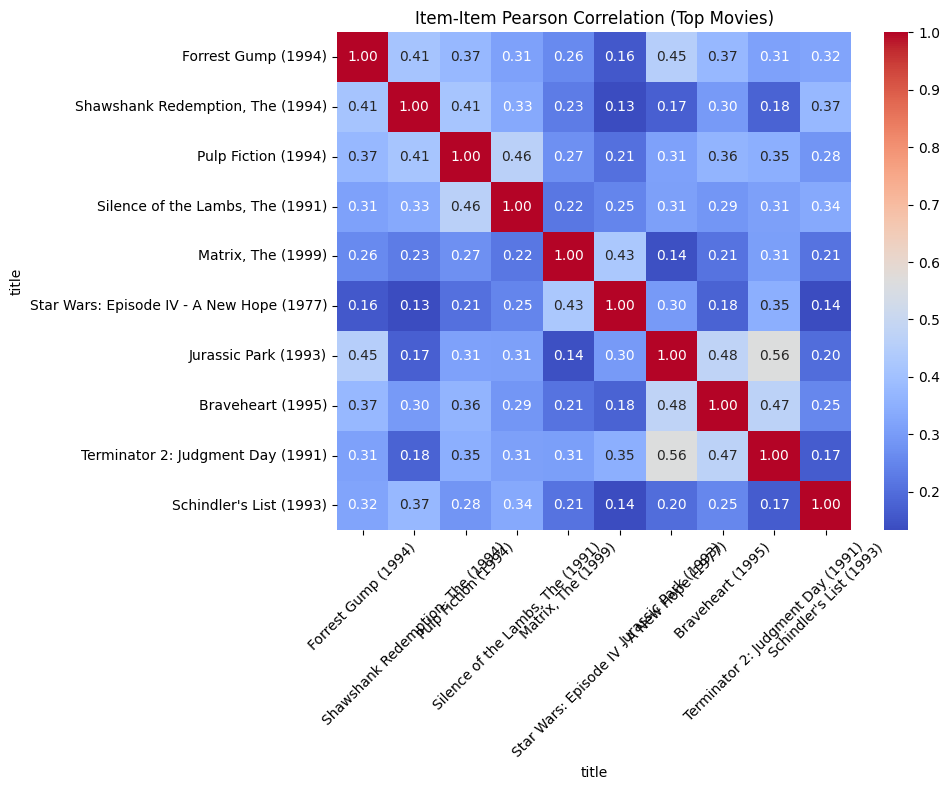

In [28]:
# Select a subset of popular movies for clearer visualization
popular_movies = df['title'].value_counts().head(10).index.tolist()
similar_subset = item_similarity.loc[popular_movies, popular_movies]

plt.figure(figsize=(10, 8))
sns.heatmap(similar_subset, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Item-Item Pearson Correlation (Top Movies)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [30]:
train_data, test_data = train_test_split(df_rating.drop('timestamp',axis = 1), test_size=0.2, random_state=42)


In [31]:
train_matrix = train_data.pivot(index='userId', columns='movieId', values='rating')
test_matrix = test_data.pivot(index='userId', columns='movieId', values='rating')

In [ ]:
df[df['userId'] == target_user]

In [32]:
# User-User Similarity
user_similarity = train_matrix.T.corr(method='pearson', min_periods=5)

# Item-Item Similarity
item_similarity = train_matrix.corr(method='pearson', min_periods=5)


In [33]:
def predict_user_based(user_id, item_id):
    if user_id not in user_similarity or item_id not in train_matrix:
        return np.nan

    user_ratings = train_matrix.loc[:, item_id]
    sim_users = user_similarity[user_id].dropna()

    relevant_users = user_ratings[sim_users.index].dropna()
    if relevant_users.empty:
        return np.nan

    sim_scores = sim_users[relevant_users.index]
    weighted_sum = (relevant_users * sim_scores).sum()
    sim_total = sim_scores.abs().sum()

    return weighted_sum / sim_total if sim_total != 0 else np.nan

def predict_item_based(user_id, item_id):
    if user_id not in train_matrix.index or item_id not in item_similarity:
        return np.nan

    user_ratings = train_matrix.loc[user_id].dropna()
    sim_items = item_similarity[item_id].dropna()

    relevant_items = user_ratings[sim_items.index].dropna()
    if relevant_items.empty:
        return np.nan

    sim_scores = sim_items[relevant_items.index]
    weighted_sum = (relevant_items * sim_scores).sum()
    sim_total = sim_scores.abs().sum()

    return weighted_sum / sim_total if sim_total != 0 else np.nan


In [40]:
def predict_user_based(user_id, item_id):
    if user_id not in user_similarity.index:
        return np.nan
    if item_id not in train_matrix.columns:
        return np.nan

    user_ratings = train_matrix[item_id]
    sim_users = user_similarity.loc[user_id].dropna()
    relevant_users = user_ratings[sim_users.index].dropna()

    if relevant_users.empty:
        return np.nan

    sim_scores = sim_users[relevant_users.index]
    weighted_sum = (relevant_users * sim_scores).sum()
    sim_total = sim_scores.abs().sum()

    return weighted_sum / sim_total if sim_total != 0 else np.nan

def predict_item_based(user_id, item_id):
    if user_id not in train_matrix.index:
        return np.nan

    user_ratings = train_matrix.loc[user_id].dropna()
    if item_id not in item_similarity.index:
        return np.nan

    sim_items = item_similarity.loc[item_id].reindex(user_ratings.index).dropna()
    relevant_ratings = user_ratings[sim_items.index]

    if relevant_ratings.empty:
        return np.nan

    weighted_sum = (relevant_ratings * sim_items).sum()
    sim_total = sim_items.abs().sum()

    return weighted_sum / sim_total if sim_total != 0 else np.nan


In [41]:
user_preds = []
item_preds = []
actuals = []

for _, row in test_data.iterrows():
    uid, iid, true_rating = row['userId'], row['movieId'], row['rating']
    ub_pred = predict_user_based(uid, iid)
    ib_pred = predict_item_based(uid, iid)

    if not np.isnan(ub_pred):
        user_preds.append(ub_pred)
    else:
        user_preds.append(train_matrix.mean().mean())  # fallback

    if not np.isnan(ib_pred):
        item_preds.append(ib_pred)
    else:
        item_preds.append(train_matrix.mean().mean())  # fallback

    actuals.append(true_rating)

# Calculate MAE
mae_user = mean_absolute_error(actuals, user_preds)
mae_item = mean_absolute_error(actuals, item_preds)


In [42]:
results = pd.DataFrame({
    "Model": ["User-Based CF", "Item-Based CF"],
    "MAE": [mae_user, mae_item]
})

print(results)


           Model       MAE
0  User-Based CF  1.402654
1  Item-Based CF  1.679208
